In [1]:
import seaborn
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from functools import lru_cache

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl.styles.stylesheet")

In [3]:
# Share of energy from renewable sources                        
NRG_IND_REN = 'data/nrg_ind_ren_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_inf_epcrw__custom_13973000/default/table?lang=en
# Electricity production capacities for renewables and wastes
NRG_INF_EPCRW = 'data/nrg_inf_epcrw_spreadsheet.xlsx'           # https://ec.europa.eu/eurostat/databrowser/view/nrg_ind_ren/default/table?lang=en    
# Simplified energy balances           
NRG_BAL_S = 'data/nrg_bal_s__custom_13973102_spreadsheet.xlsx'  # https://ec.europa.eu/eurostat/databrowser/view/nrg_bal_s__custom_13973102/default/table?lang=en
# Supply and transformation of solid fossil fuels
NRG_CB_SFFM = 'data/nrg_cb_sffm_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_sffm/default/table?lang=en 
# Electricity prices for household consumers          
NRG_PC_204 = 'data/nrg_pc_204_spreadsheet.xlsx'                 # https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_204/default/table?lang=en 
# Gross domestic product at market prices
EDAT_LFSE_03 = 'data/edat_lfse_03_spreadsheet.xlsx'             # https://ec.europa.eu/eurostat/databrowser/view/tec00001/default/table?lang=en 

In [4]:
@lru_cache
def eurostat_dataset(path: str) -> pd.DataFrame:

    # retrieve sheets data and metadata from Summary sheet
    ## the time frequency and unit of measurement information 
    # is not a relevant index value since they are always the same
    ignore = ['Time frequency', 'Unit of measure']
    summary = pd.read_excel(
        path, sheet_name='Summary', 
        usecols=lambda col: \
            not col.startswith('Unnamed') and col not in ignore,
        index_col='Contents', skiprows=14
    )

    all = []

    # iterate over data sheets and pre-process them
    for sheet_name, config in summary.iterrows():

        # the valuable information starts with the row containing "TIME" indicating the start of the data table
        preview = pd.read_excel(path, sheet_name=sheet_name, usecols=[0])
        header_row = preview[preview.iloc[:, 0] == 'TIME'].index[0]

        data = pd.read_excel(
            path, sheet_name=sheet_name,
            usecols= lambda col: not str(col).startswith('Unnamed'),
            na_values=':', skiprows=header_row + 1
        )

        # Remove the first row "Geo (Label)"
        data = data.iloc[1:].reset_index(drop=True)

        # some sheets contain additional meta-data at the end which are seperated by a NaN value row from the actual data
        ## if we find such a row we remove all rows after
        first_blank_row_index = data.isnull().all(axis=1).idxmax() if data.isnull().all(axis=1).any() else None
        if first_blank_row_index is not None:
            data = data.loc[:first_blank_row_index - 1]

        # rename TIME to country
        data.rename(columns={'TIME': 'Country'}, inplace=True)

        # create multi-index based on config
        config_df = pd.DataFrame([config] * len(data), index=data.index)
        data = pd.concat([config_df, data], axis=1)
        data.set_index(['Country'] + list(config_df.columns), inplace=True)

        all.append(data)

    # merge them into one multi-index data frame 
    all = pd.concat(all).sort_index()
    
    return all

## Question 1: How is the adoption of renewable energy in Europe evolving?

In [5]:
energy_share = eurostat_dataset(NRG_IND_REN)

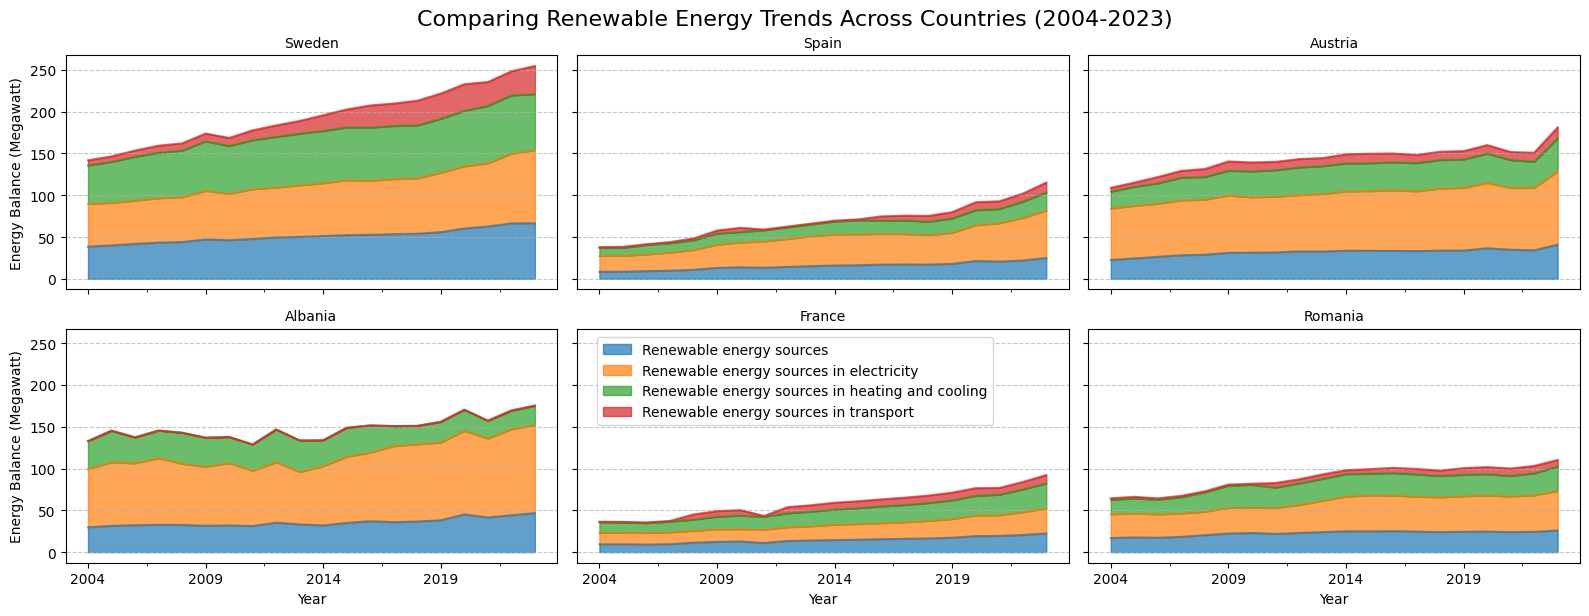

In [6]:
# Select a subset of countries for comparison
countries_to_compare = ("Sweden", "Spain", "Austria", "Albania", "France", "Romania")
comparison_data = energy_share.loc[energy_share.index.get_level_values('Country').isin(countries_to_compare)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(countries_to_compare):
    country_data = comparison_data.loc[country]
    
    country_data.T.plot(kind='area', stacked=True, alpha=0.7, ax=axes[idx], legend=False)
    
    axes[idx].set_title(country, fontsize=10)
    axes[idx].set_xlabel("Year", fontsize=10)
    axes[idx].set_ylabel("Energy Balance (Megawatt)", fontsize=10)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 0.4), ncol=1, fontsize=10)

plt.tight_layout()
plt.suptitle("Comparing Renewable Energy Trends Across Countries (2004-2023)", fontsize=16, y=1.02)
plt.show()

In [7]:
melted_data = energy_share.reset_index().melt(id_vars=["Country", "Energy balance"], var_name="Year", value_name="Energy Balance")

renewable_data = melted_data[melted_data["Energy balance"] == "Renewable energy sources"].copy()
renewable_data["Year"] = renewable_data["Year"]
renewable_data["Energy Balance"] = renewable_data["Energy Balance"].infer_objects()

fig = px.choropleth(
    renewable_data,
    range_color=(renewable_data['Energy Balance'].min(), renewable_data['Energy Balance'].max()),
    locations="Country",
    locationmode="country names",
    color="Energy Balance",
    projection="natural earth",
    hover_name="Country",
    animation_frame="Year",
    # title="Renewable Energy Trends Across the EU (2004-2023)",
    scope="europe"
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Question 2: How is the adoption of different types of renewable energyevolving?

In [8]:
# TODO: work on it
energy_prod_cap = eurostat_dataset(NRG_INF_EPCRW)
energy_prod_cap

1990  \
Country        Standard international energy product classific... Technical characteristics of plants                       
Albania        Biogases                                           Net maximum electrical capacity                       0   
                                                                  Net maximum electrical capacity - alternating c...  NaN   
                                                                  Net maximum electrical capacity - direct current    NaN   
               Geothermal                                         Net maximum electrical capacity                       0   
                                                                  Net maximum electrical capacity - alternating c...  NaN   
...                                                                                                                   ...   
United Kingdom Wind off shore                                     Net maximum electrical capacity - alternating c...  NaN   
                                                                  Net maximum electrical capacity - direct current    NaN   
               Wind on shore                                      Net maximum electrical capacity                       0   
                                                                  Net maximum electrical capacity - alternating c...  NaN   
                                                                  Net maximum electrical capacity - direct current    NaN   

                                                                                                                      1991  \
Country        Standard international energy product classific... Technical characteristics of plants                        
Albania        Biogases                                           Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacity - alternating c...   NaN   
                                                                  Net maximum electrical capacity - direct current     NaN   
               Geothermal                                         Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacity - alternating c...   NaN   
...                                                                                                                    ...   
United Kingdom Wind off shore                                     Net maximum electrical capacity - alternating c...   NaN   
                                                                  Net maximum electrical capacity - direct current     NaN   
               Wind on shore                                      Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacity - alternating c...   NaN   
                                                                  Net maximum electrical capacity - direct current     NaN   

                                                                                                                      1992  \
Country        Standard international energy product classific... Technical characteristics of plants                        
Albania        Biogases                                           Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacity - alternating c...   NaN   
                                                                  Net maximum electrical capacity - direct current     NaN   
               Geothermal                                         Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacit

## Question 3: Are there characteristics of countries that correlate with theirlevel of adoption of renewable energy?

In [9]:
# TODO: work on it
energy_prices = eurostat_dataset(NRG_PC_204)
energy_prices

2007-S1  \
Country        Products          Energy consumption                           Taxes                                              Currency                            
Albania        Electrical energy Consumption for 15 000 kWh or over - band DE All taxes and levies included                      Euro                          NaN   
                                                                                                                                 National currency             NaN   
                                                                                                                                 Purchasing Power Standard     NaN   
                                                                              Excluding VAT and other recoverable taxes and l... Euro                          NaN   
                                                                                                                                 National currency             NaN   
...                                                                                                                                                            ...   
United Kingdom Electrical energy Consumption of kWh - all bands               Excluding VAT and other recoverable taxes and l... National currency             NaN   
                                                                                                                                 Purchasing Power Standard     NaN   
                                                                              Excluding taxes and levies                         Euro                          NaN   
                                                                                                                                 National currency             NaN   
                                                                                                                                 Purchasing Power Standard     NaN   

                                                                                                                                                            2007-S2  \
Country        Products          Energy consumption                           Taxes                                              Currency                             
Albania        Electrical energy Consumption for 15 000 kWh or over - band DE All taxes and levies included                      Euro                           NaN   
                                                                                                                                 National currency              NaN   
                                                                                                                                 Purchasing Power Standard      NaN   
                                                                              Excluding VAT and other recoverable taxes and l... Euro                           NaN   
                                                                                                                                 National currency              NaN   
...                                                                                                                                                             ...   
United Kingdom Electrical energy Consumption of kWh - all bands               Excluding VAT and other recoverable taxes and l... National currency              NaN   
                                                                                                                                 Purchasing Power Standard      NaN   
                                                                              Excluding taxes and levies                         Euro                           NaN   
                                                                                                                                 National currency             